# PCA Plots

## General settings and loading files

In [1]:
%%time

% matplotlib inline
% load_ext autoreload
% autoreload 2

% run general_settings.py
# ^ Takes ~20s to run if it finds the dumpfiles
# ^ WARNING: It will hog ~2.02 Gb RAM

[12:26:17] 'panels' dict
[12:26:17] 'galanter', 'present', 'missing' dataframes
[12:26:17] 'panel_labels'
[12:26:17] 'panel_names' dict
[12:26:17] 'panel_rsIDs' dict
[12:26:17] 'genome' dataframe
[12:26:24] 'lat' dataframe
[12:26:38] 'control_genotypes' huge datagrame
[12:26:38] 'control_rsIDs' dict to filter it ^
[12:26:38] 'cp_factors' list
[12:26:38] 'control_names' dict
[12:26:38] 'df_1000G_samples'
[12:26:38] 'df_1000G_SNPs'
[12:26:38] 'df_1000G_genotypes'
[12:26:38] 'df_1000G_populations'
[12:26:38] 'df_1000G_genotypes_alleles'

/home/juan/repos/tesina/settings/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



[12:26:39] 'mafs' dataframe
CPU times: user 17.4 s, sys: 3.9 s, total: 21.3 s
Wall time: 22 s


/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


## Create the datasets
Lists of sample IDs of chosen populations to later filter 1000 Genomes data.

In [2]:
% run datasets_settings.py

! echo; wc -l /home/juan/tesina/dataset_dumps/*.samples | grep -v total

[12:26:39] 'dataset_names'
[12:26:39] 'dataset_populations'
[12:26:39] 'dataset_samples' created and written to files

  346 /home/juan/tesina/dataset_dumps/L.samples
  544 /home/juan/tesina/dataset_dumps/LE.samples
  751 /home/juan/tesina/dataset_dumps/LEA.samples
  959 /home/juan/tesina/dataset_dumps/LEAC.samples
 1062 /home/juan/tesina/dataset_dumps/LEACI.samples


In [8]:
for label, ary in dataset_samples.items():
    print(len(ary), dataset_names[label])

347 Latinos
545 Latinos, Europeos
752 Latinos, Europeos, Africanos
960 Latinos, Europeos, Africanos, Chinos
1063 Latinos, Europeos, Africanos, Chinos, Indios


## PCA plots

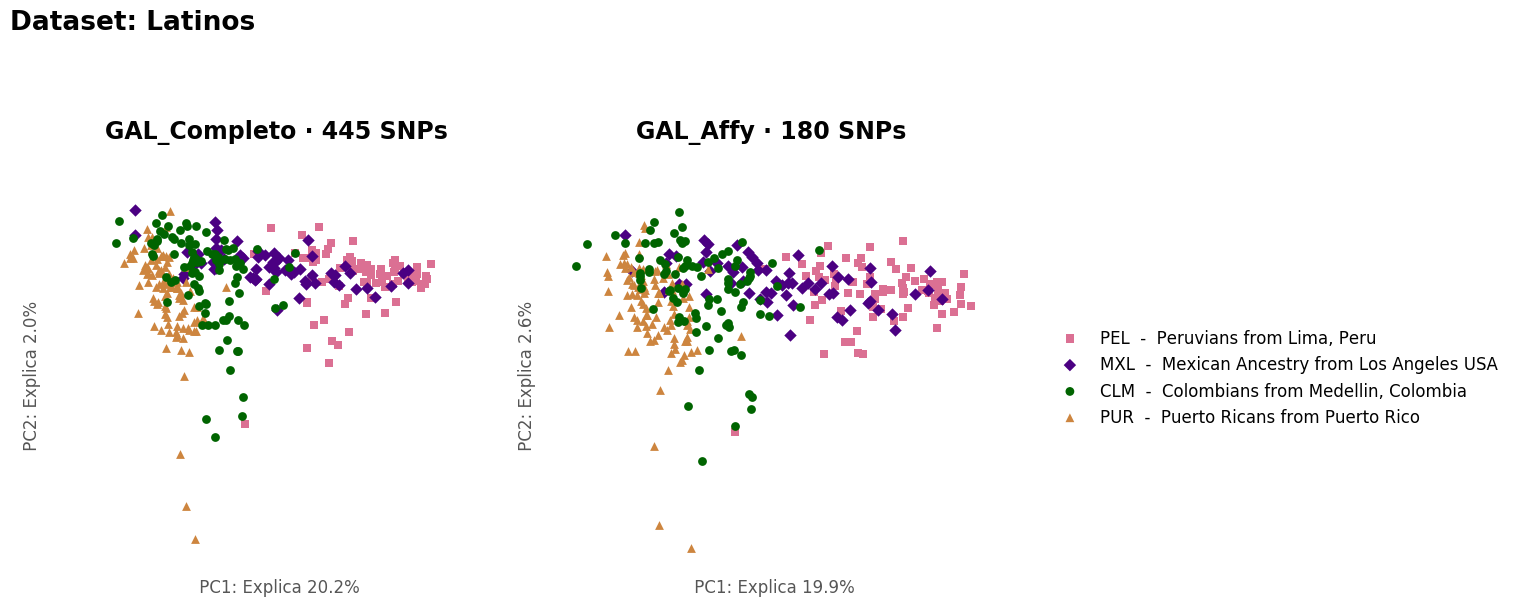

In [ ]:
%%time

# == WARNING ==
# This cell will take ~4m to execute

from plotters.pca import PCAPlotter

pca_plotter = PCAPlotter()
components_to_compare = [("PC1", "PC2")]

def make_filename(dataset_label, panel_labels, components_to_compare):
    return "{}_{}_PCx{}".format(dataset_label,
                                "_".join(panel_labels),
                             len(components_to_compare) * 2)

for dataset_label, sample_ids in dataset_samples.items():
    
    
    fig_title = "Dataset: {}".format(dataset_names[dataset_label])

    # GAL Panles
    dataset_genotypes = df_1000G_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, panel_labels, components_to_compare)
    populations_to_plot = dataset_populations[dataset_label]  # Order to the plot!
    pca_plotter.plot(fig_title, panel_rsIDs, dataset_genotypes, df_1000G_samples,
                     components_to_compare, panel_names, filename,
                     populations_to_plot)
    
    # Control Panels
    dataset_genotypes = control_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, control_labels, components_to_compare)
    populations_to_plot = dataset_populations[dataset_label]  # Order to the plot!
    pca_plotter.plot(fig_title, control_rsIDs, dataset_genotypes, df_1000G_samples,
                     components_to_compare, control_names, filename,
                     populations_to_plot)
    
    # Control Panels - Extra components
    only_big_cp = {"100": control_rsIDs["100"]}
    more_components_to_compare = [("PC3", "PC4"), ("PC5", "PC6"),
                                  ("PC7", "PC8")]
    dataset_genotypes = control_genotypes.loc[sample_ids, :]
    populations_to_plot = dataset_populations[dataset_label]  # Order to the plot!
    filename = make_filename(dataset_label, ["100"], more_components_to_compare)
    pca_plotter.plot(fig_title, only_big_cp, dataset_genotypes, df_1000G_samples,
                     more_components_to_compare, control_names, filename,
                     populations_to_plot)